In [1]:
from gibbs import *
from data_simu import *
from mcmc_plot import *
from geweke_full import *
from data_pertub import *

## 1.Simulate Data

I simulate the data according to 

$$X= WZ + \sigma^2 I_n$$
where 

 1. $\sigma^2$ is a scalar for the noise parameter
 2. $(Z_i)_{qx1} \sim N(0, I_q)$ is the principle component vector for i-th observation
 3. $(\alpha_j)_{}$ is the precision vector parameter for $W$ matrix
 4. $(W_j)_{dx1} \sim N(0, v_jI_d)$ is the j-th column of $W$ projection matrix

In the following simualation, I chose d = 5, q_star = 1, meaning there is only one important component driving 5 dimensional data $X$

In [2]:
# data dimension
d = 5
# true component dimension
q_star = d-1
# sample size
n_sample = 1000
# true sigma2
sigma2_star = 1
# true component variance parameter
a_star_list = 1 / np.linspace(1,10,q_star)

In [3]:
X = generate_data(d, q_star, n_sample, sigma2_star, a_star_list)

Text(0, 0.5, 'Component j')

<Figure size 720x432 with 0 Axes>

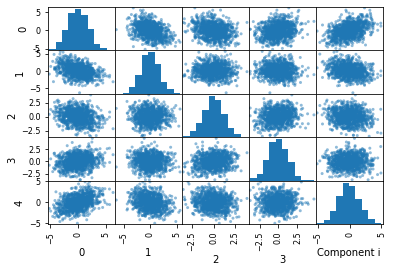

In [4]:
plt.figure(figsize=(10,6))
pd.plotting.scatter_matrix(pd.DataFrame(X).T)
plt.xlabel('Component i')
plt.ylabel('Component j')

In [5]:
def component_posterior(comp_index, W_list, Z_list):
    """
        Function to plot the component residuals
        param: comp_index. list of compoents indexs used to restore the original data X
    """
    x_list=[]
    for sub_chains in range(n_chains):

        for iters in range(len(W_list[sub_chains])):
            y_hat = np.dot(W_list[sub_chains][iters][:,comp_index].reshape([d,len(comp_index)]), Z_list[sub_chains][iters][comp_index,:].reshape([len(comp_index),n_sample]))

            x_list.append(X-y_hat)
    return x_list

## 2. Geweke Test

### 2.1 Geweke Test Setup

I simulate the data generating process iteration(500) tims and sample mcmc iteration(500) times to calcualte some statistics on the data X. The mcmc sample was thined by draw 1 sample evert 50 times

In [6]:
q = d-1
a_vj = 0.5 * d * np.ones(q) + 1
epislon = 0.1

prior_param = dict({'beta_sigma2': 2,
                        'a_sigma2': 3,
                        'a_vj': a_vj,
                        'beta_vj': epislon * (a_vj - 1)
                        })

init_dict = dict({'Z0': np.random.normal(0, 1, [q, 1]),
                      "sigma20": np.random.gamma(3, 0.1),
                      "w0": np.random.normal(0, 1, [d, q]),
                      "v0": np.random.gamma(1, 2, d - 1)})   


iterations = 500
n_sample = 500
thin = 50

### 2.2 Geweke Result --- PP plot, density plot and autocorrelation plot

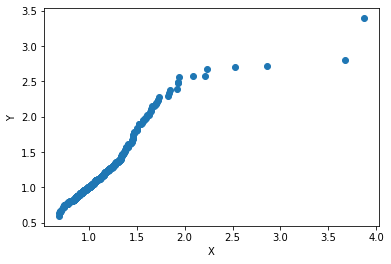

0.9516040595897288


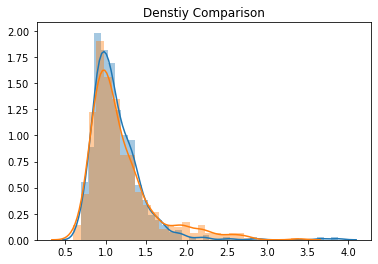

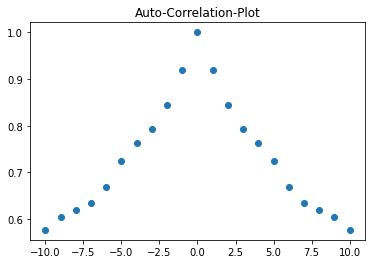

In [7]:
forward_results, gibbs_results = geweke(iterations, d, q_star, prior_param, init_dict, n_sample, thining= thin)

plt.scatter(np.sort(np.array(forward_results)),
            np.sort(np.array(gibbs_results)))
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


print(np.mean(np.array(forward_results)) / np.mean(gibbs_results))


sns.distplot(np.array(forward_results))
sns.distplot(np.array(gibbs_results))
plt.title('Denstiy Comparison')
plt.show()

a = gibbs_results
b = np.mean(gibbs_results)
plt.acorr(a - b, normed=True, usevlines=False, maxlags=10, label=u'thinned')
plt.title('Auto-Correlation-Plot')
plt.show()

## 3. Gibbs Sampling

In [8]:
config = configparser.ConfigParser()
config.sections()
# for i in os.listdir('param2/'):
config.read("10000.ini")
data_config = dict(config['data_config'])


In [9]:
n_sample = int(data_config['n_sample'])
alpha = float(data_config['alpha'])


d = int(data_config['d'])
q_star = int(data_config['q_star'])
a_vj = float(data_config['a_vj']) * np.ones(q_star)
epislon = float(data_config['epislon'])
beta_vj = epislon * (a_vj - 1)
beta_sigma2 = float(data_config['beta_sigma2'])
a_sigma2 = float(data_config['a_sigma2'])

prior_param_true = dict({'beta_sigma2': beta_sigma2,
                    'a_sigma2': a_sigma2,
                    'a_vj': a_vj,
                    'beta_vj': beta_vj
                    })


true sigma2_star is0.004149103744531533


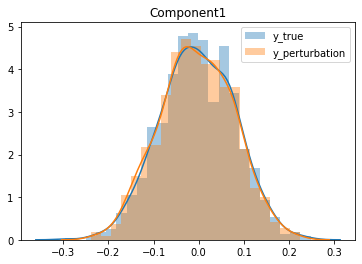

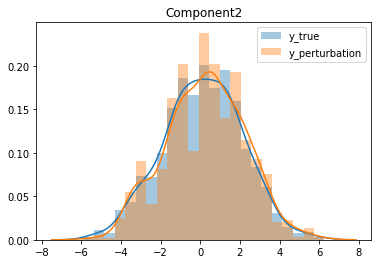

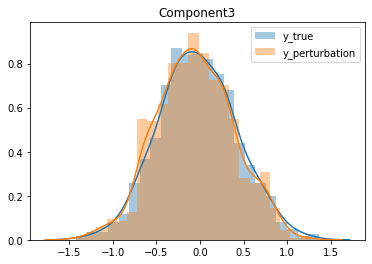

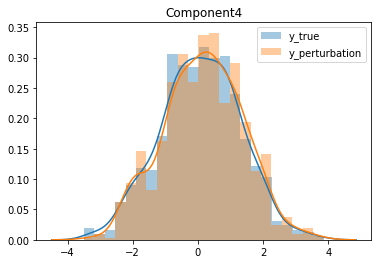

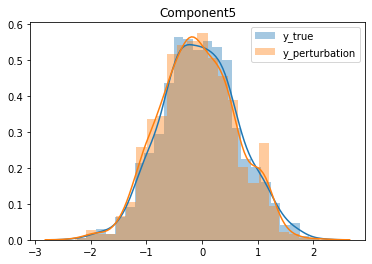

In [10]:
y_true = forward_sample(d, q_star, n_sample, prior_param_true, verbose = True)
y_perturbation = sample_perturbation2(y_true, n_sample, 500)
#y_perturbation = forward_sample(d, q_star, n_sample, prior_param_true, verbose = True)

for j in range(d):    
    sns.distplot(y_true[j,:], label='y_true')
    sns.distplot(y_perturbation[j,:], label='y_perturbation')
    plt.legend()
    plt.title('Component '+ str(j+1))
    plt.show()

In [11]:
X = y_true

### 3.1 Prior Parameter Setup

In [13]:
config = configparser.ConfigParser()
config.sections()
# for i in os.listdir('param2/'):
config.read("10000.ini")
mcmc_setup = dict(config['mcmc_setup'])

In [14]:
# inference parameter
d = int(data_config['d'])
q = int(mcmc_setup['q'])
xi = float(mcmc_setup['xi'])


# prior parameter
beta_sigma2 = float(mcmc_setup['beta_sigma2'])
a_sigma2 = float(mcmc_setup['a_sigma2'])
a_vj = float(mcmc_setup['a_vj']) * np.ones(q_star)
epislon = float(mcmc_setup['epislon'])
beta_vj = epislon * (a_vj - 1)


# sampling parameter
prior_param_mcmc = dict({'beta_sigma2': beta_sigma2,
                    'a_sigma2': a_sigma2,
                    'a_vj': a_vj,
                    'beta_vj': beta_vj
                    })


Mean of true sigma2 0.010123854138917632


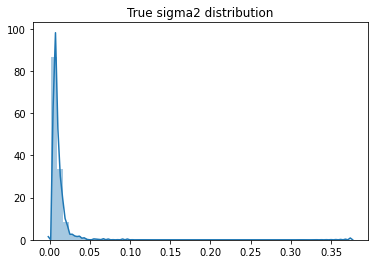

In [15]:
true_sigma2_sample = 1/np.random.gamma(prior_param_true['a_sigma2'], 1/ prior_param_true['beta_sigma2'], 1000 )
sns.distplot(true_sigma2_sample)
plt.title('True sigma2 distribution')
print('Mean of true sigma2 '+ str(np.mean(true_sigma2_sample)))

### 3.2 Inference Parameter Setup

In [16]:
n_chains = int(mcmc_setup['n_chains'])
iterations = int(mcmc_setup['iterations'])

### 3.3 Inference Sampling standard

In [17]:
mcmc_list = []
for sub_chains in range(n_chains):    
    init_dict = dict({'Z0': np.random.normal(0, 1, [q, 1]),
                      "sigma20": np.random.gamma(prior_param_mcmc['a_sigma2'], 1/prior_param_mcmc['beta_sigma2']),
                      "w0": np.random.normal(0, 1, [d, q]),
                      "v0": np.random.gamma(1, 2, d - 1)})   
                      
    inference = Model(X, init_dict, iterations, q, prior_param_mcmc, xi = 1)                      
    mcmc_list.append(inference.gibbs_result())

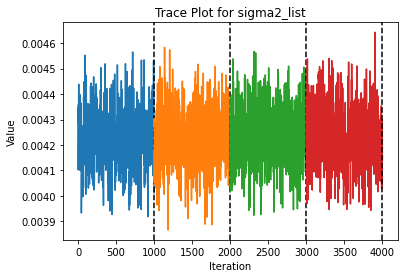

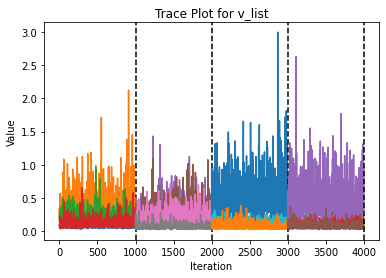

In [18]:
var_list = ['sigma2_list', 'v_list']
trace_plot(mcmc_list, var_list)

In [19]:
sigma2_list = get_trace_list(mcmc_list, 'sigma2_list')
Z_list = get_trace_list(mcmc_list, 'Z_list')
W_list = get_trace_list(mcmc_list, 'W_list')
v_list = get_trace_list(mcmc_list, 'v_list')

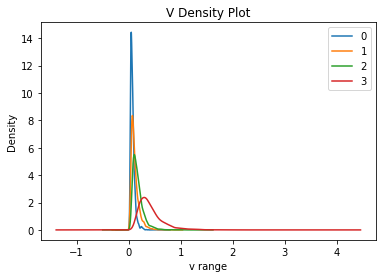

In [20]:
v_table = plot_v_density(v_list)

In [21]:
np.mean(v_list, axis=1)

array([[0.09622648, 0.37929959, 0.20044619, 0.11937807],
       [0.27126446, 0.25527522, 0.19848378, 0.06761148],
       [0.06068018, 0.13312646, 0.53916367, 0.0851105 ],
       [0.08478459, 0.12342724, 0.48374064, 0.07800151]])

In [22]:
print('Inference v' + str(v_table.mean().values))

print('True v'+ str(prior_param_true['beta_vj']/prior_param_true['a_vj']))

Inference v[0.07562991 0.12193923 0.17806878 0.41836709]
True v[1.42857143]


### 3.4 Inference Sampling Approxmiate

In [23]:
mcmc_list = []
for sub_chains in range(n_chains):    
    init_dict = dict({'Z0': np.random.normal(0, 1, [q, 1]),
                      "sigma20": np.random.gamma(prior_param_mcmc['a_sigma2'], 1/prior_param_mcmc['beta_sigma2']),                      
#                      "sigma20": np.random.gamma(3, 0.1),
                      "w0": np.random.normal(0, 1, [d, q]),
                      "v0": np.random.gamma(1, 2, d - 1)})   
                      
    inference = Model(X, init_dict, iterations, q, prior_param_mcmc, xi = xi)                      
    mcmc_list.append(inference.gibbs_result())

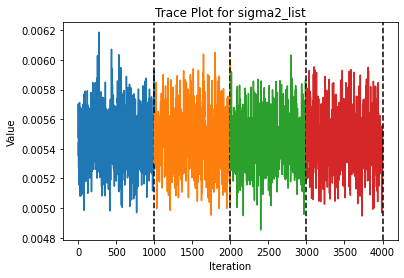

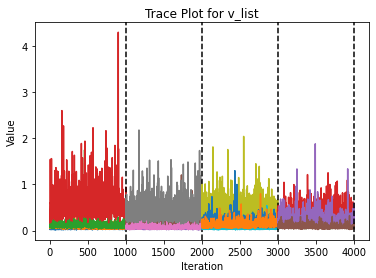

In [24]:
var_list = ['sigma2_list', 'v_list']
trace_plot(mcmc_list, var_list)

In [25]:
sigma2_list = get_trace_list(mcmc_list, 'sigma2_list')
Z_list = get_trace_list(mcmc_list, 'Z_list')
W_list = get_trace_list(mcmc_list, 'W_list')
v_list = get_trace_list(mcmc_list, 'v_list')

In [26]:
np.mean(sigma2_list)

0.005458135281917881

array([[0.05149846, 0.07876042, 0.1252313 , 0.5947836 ],
       [0.05421664, 0.24810728, 0.07093646, 0.43228415],
       [0.44116557, 0.05392355, 0.17515855, 0.13472872],
       [0.12451011, 0.35527113, 0.23803323, 0.08557224]])

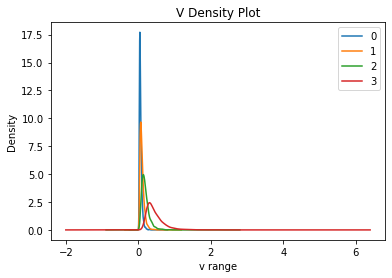

In [27]:
v_table = plot_v_density(v_list)
np.mean(v_list, axis=1)

In [28]:
print('Inference v' + str(v_table.mean().values))

print('True v'+ str(prior_param_true['beta_vj']/prior_param_true['a_vj']))

Inference v[0.06130272 0.10223393 0.19663259 0.45587611]
True v[1.42857143]


In [29]:
from scipy import optimize

def diff(sigma2, X, robust_sigma2):
    X_WZ = X- np.dot(W_list[-1][-1],Z_list[-1][-1])
    S_x = np.trace(np.dot(X_WZ.T, X_WZ))    
    y_hat = -n_sample * xi/2 * d * np.log(np.pi*2*robust_sigma2) - 0.5 * xi / robust_sigma2 * S_x    
    standard_like = -n_sample /2 * d * np.log(np.pi*2 *sigma2)  - 0.5 / sigma2 * S_x    
    diff = (y_hat-standard_like)**2
#    diff = np.abs(y_hat-standard_like)
    return diff
        
    
results = optimize.minimize_scalar(diff, bounds=(0,1), method='bounded', args=(X, np.mean(sigma2_list)))
#(diff, 0.341, args=(X, np.mean(sigma2_list)))
results.x

0.030596397549270186

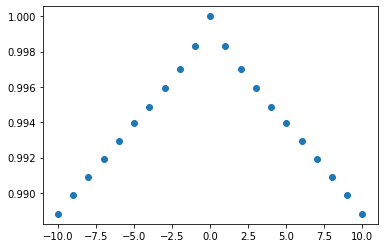

In [30]:
plt.acorr(sigma2_list[0], normed=True, usevlines=False, maxlags=10, label=u'thinned')
plt.show()